In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import model_selection, preprocessing
import seaborn as sns
import xgboost as xgb
import datetime

train = pd.read_csv("input/train.csv.zip", compression="zip", delimiter=",")
test = pd.read_csv("input/test.csv.zip", compression="zip", delimiter=",")
macro = pd.read_csv("input/macro.csv.zip", compression="zip", delimiter=",")

pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

height has been deprecated.



/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


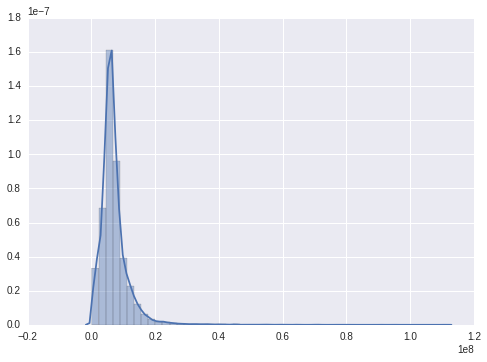

In [2]:
sns.distplot(train["price_doc"].values)

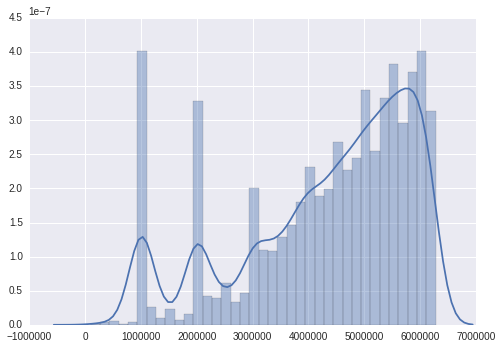

In [3]:
sns.distplot(train[train["price_doc"] <= 6283459]["price_doc"].values)

In [4]:
max(train["price_doc"])

111111112

In [5]:
min(train["price_doc"])

100000

In [6]:
np.mean(train["price_doc"])

7123035.2777394904

In [7]:
train["timestamp"].apply( lambda x: str(x)[:4]).unique()

array(['2011', '2012', '2013', '2014', '2015'], dtype=object)

In [8]:
train["timestamp"] = pd.to_datetime(train["timestamp"])
train["timestamp"].apply( lambda x: str(x)[:4]).unique()

array(['2011', '2012', '2013', '2014', '2015'], dtype=object)

In [9]:
train["day"] = train["timestamp"].dt.day

In [10]:
train["month"] = train["timestamp"].dt.month

In [11]:
train["year"] = train["timestamp"].dt.year
train["year"].unique()

array([2011, 2012, 2013, 2014, 2015])

In [12]:
train['yearmonth'] = train['timestamp'].apply(lambda x: str(x)[:4]+str(x)[5:7])

In [13]:
test["timestamp"] = pd.to_datetime(test["timestamp"])
test["year"], test["month"], test["day"] = test["timestamp"].dt.year,test["timestamp"].dt.month,test["timestamp"].dt.day
test['yearmonth'] = test['timestamp'].apply(lambda x: str(x)[:4]+str(x)[5:7])

In [14]:
train["count"] = 1

In [15]:
count_year_train = train.groupby("year").count().reset_index()

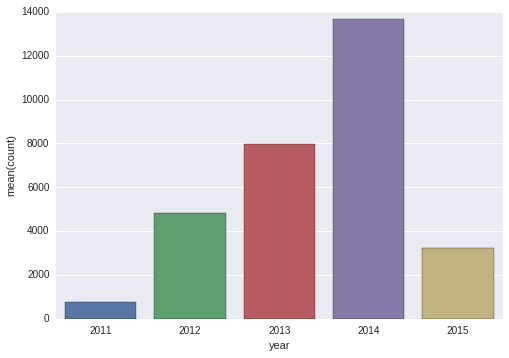

In [16]:
sns.barplot(count_year_train["year"], count_year_train["count"])

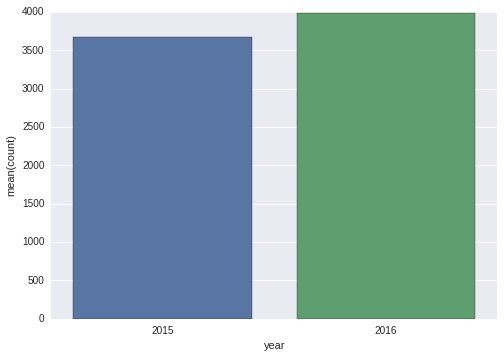

In [17]:
test["count"] = 1
count_year_test = test.groupby("year").count().reset_index()
sns.barplot(count_year_test["year"], count_year_test["count"])

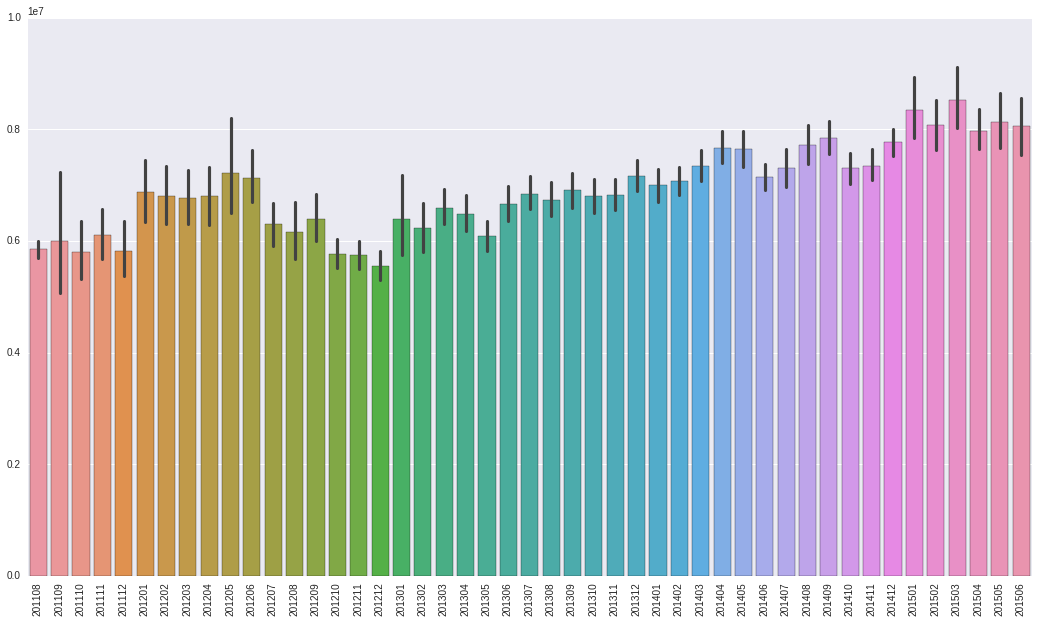

In [18]:
train.groupby("yearmonth").aggregate(np.mean).reset_index()
plt.figure(figsize= (18,10))
plt.xticks(rotation="vertical")
sns.barplot(train["yearmonth"].values, train["price_doc"].values)

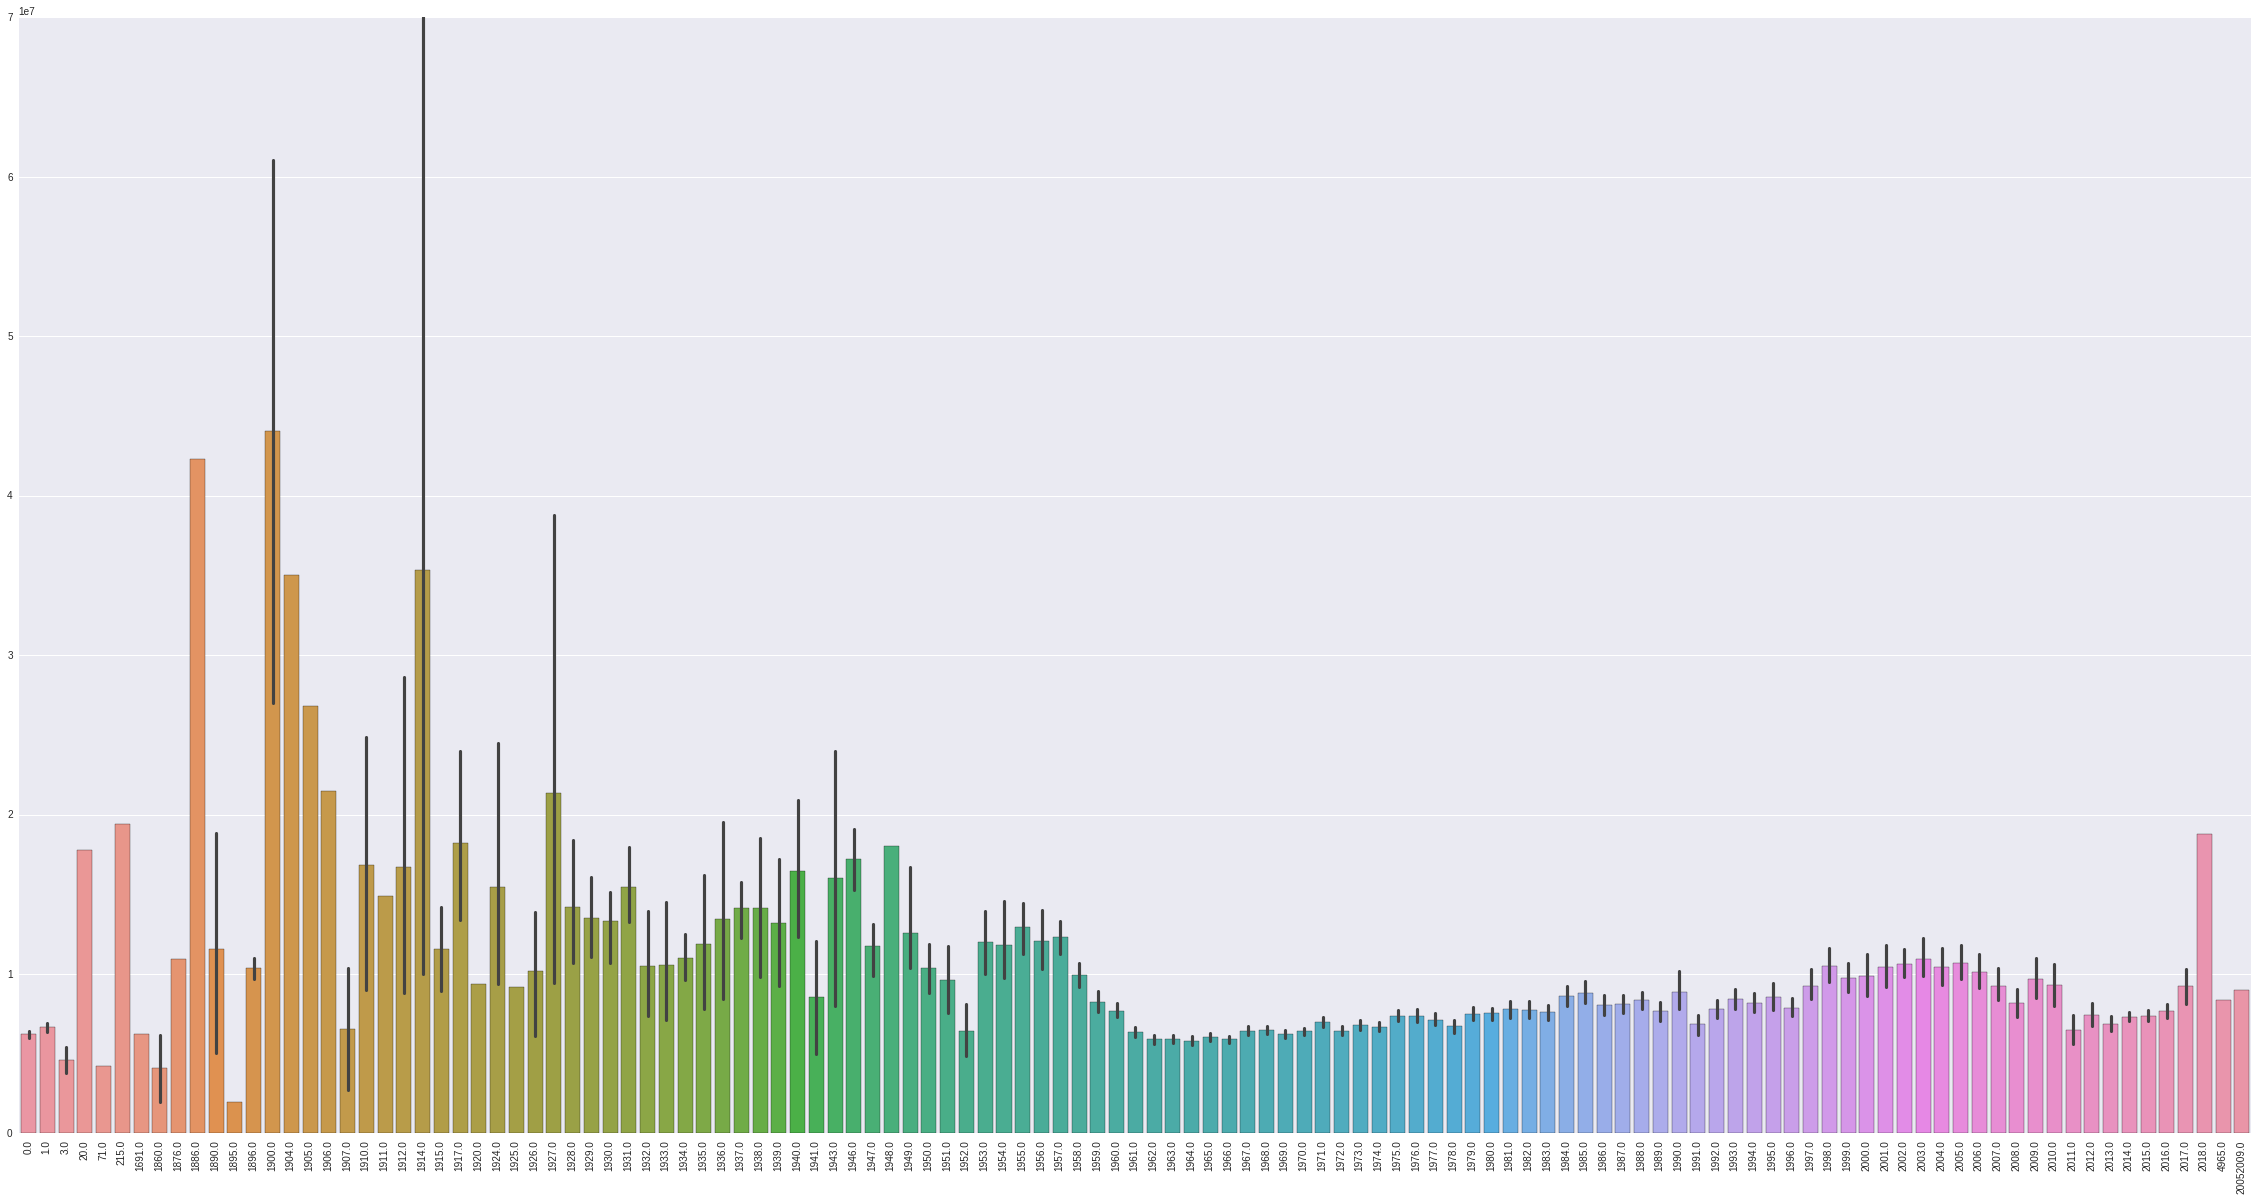

In [19]:
train.groupby("build_year").aggregate(np.mean).reset_index()
plt.figure(figsize= (40,20))
plt.xticks(rotation="vertical")
sns.barplot(train["build_year"].values, train["price_doc"].values)

### As we can see in the plot above, there are many incorrect values in the build year feature

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


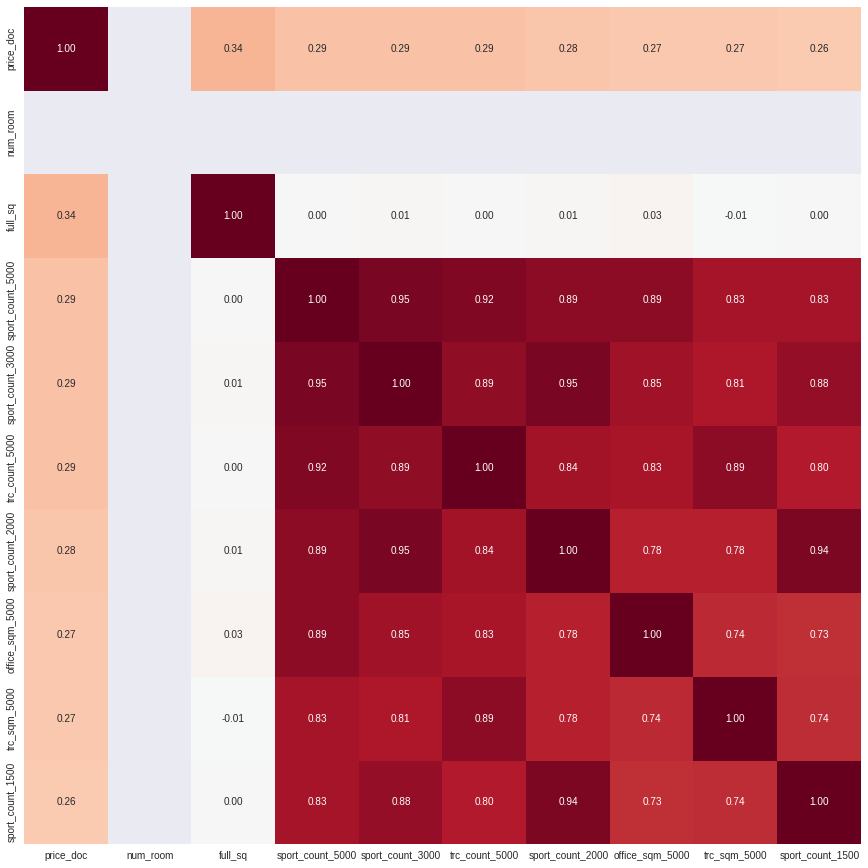

In [20]:
corr = train.corr()

cols = corr.nlargest(10, "price_doc")["price_doc"].index

cm = np.corrcoef(train[cols].values.T)
f, ax = plt.subplots(figsize=(15,15))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

### This is the correlation matrix 

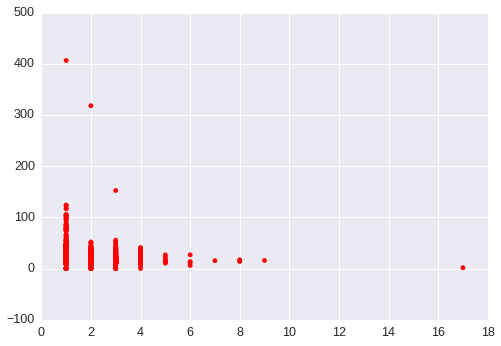

In [21]:
small_train = train.dropna()
square_per_room = small_train["life_sq"]/small_train["num_room"]

plt.scatter(small_train["num_room"],square_per_room,color="red")

### NEXT is based on
https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
http://machinelearningmastery.com/an-introduction-to-feature-selection/
http://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/
https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/
##### Further reading
http://www.kdnuggets.com/2017/05/learn-machine-learning-10-days.html?utm_content=buffer46c1d&utm_medium=social&utm_source=facebook.com&utm_campaign=buffer
http://www.kdnuggets.com/2017/03/6-business-concepts-data-science-unicorn.html?utm_content=buffer7e2af&utm_medium=social&utm_source=facebook.com&utm_campaign=buffer

In [22]:
macro = pd.read_csv("input/macro.csv.zip", compression = "zip")

In [25]:
macro

,timestamp,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,eurrub,brent,net_capital_export,gdp_annual,gdp_annual_growth,average_provision_of_build_contract,average_provision_of_build_contract_moscow,rts,micex,micex_rgbi_tr,micex_cbi_tr,deposits_value,deposits_growth,deposits_rate,mortgage_value,mortgage_growth,mortgage_rate,grp,grp_growth,income_per_cap,real_dispos_income_per_cap_growth,salary,salary_growth,fixed_basket,retail_trade_turnover,retail_trade_turnover_per_cap,retail_trade_turnover_growth,labor_force,unemployment,employment,invest_fixed_capital_per_cap,invest_fixed_assets,profitable_enterpr_share,unprofitable_enterpr_share,share_own_revenues,overdue_wages_per_cap,fin_res_per_cap,marriages_per_1000_cap,divorce_rate,construction_value,invest_fixed_assets_phys,pop_natural_increase,pop_migration,pop_total_inc,childbirth,mortality,housing_fund_sqm,lodging_sqm_per_cap,water_pipes_share,baths_share,sewerage_share,gas_share,hot_water_share,electric_stove_share,heating_share,old_house_share,average_life_exp,infant_mortarity_per_1000_cap,perinatal_mort_per_1000_cap,incidence_population,rent_price_4+room_bus,rent_price_3room_bus,rent_price_2room_bus,rent_price_1room_bus,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,load_of_teachers_preschool_per_teacher,child_on_acc_pre_school,load_of_teachers_school_per_teacher,students_state_oneshift,modern_education_share,old_education_build_share,provision_doctors,provision_nurse,load_on_doctors,power_clinics,hospital_beds_available_per_cap,hospital_bed_occupancy_per_year,provision_retail_space_sqm,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,2010-01-01,76.1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38807.2,-0.078209,5.00,NaN,NaN,NaN,NaN,NaN,7484970,NaN,NaN,142968,NaN,13.72,8375.8638,NaN,30789.2,0.038,38410.5,NaN,11443.63,2882.4169,251.484,106.8,6436.244,0.018,0.69,63932.0,732.760604,0.716,0.284,0.962915,12865.0,233.351529,8.0,3.9,553874.9,95.8,-0.3,14.1,13.8,10.7,11.0,216.0,18.715883,99.9,99.8,99.6,44.4,95.7,55.0,99.9,0.3,74.2,6.1,5.87,696.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,721.477765,"45,713",1356.112607,NaN,NaN,NaN,18.0,99.4,7872.848285,162.9,NaN,NaN,NaN,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
1,2010-01-02,76.1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38807.2,-0.078209,5.00,NaN,NaN,NaN,NaN,175.15,7484970,NaN,NaN,142968,NaN,13.72,8375.8638,NaN,30789.2,0.038,38410.5,NaN,11443.63,2882.4169,251.484,106.8,6436.244,0.018,0.69,63932.0,732.760604,0.716,0.284,0.962915,12865.0,233.351529,8.0,3.9,553874.9,95.8,-0.3,14.1,13.8,10.7,11.0,216.0,18.715883,99.9,99.8,99.6,44.4,95.7,55.0,99.9,0.3,74.2,6.1,5.87,696.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,721.477765,"45,713",1356.112607,NaN,NaN,NaN,18.0,99.4,7872.848285,162.9,NaN,NaN,NaN,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
2,2010-01-03,76.1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38807.2,-0.078209,5.00,NaN,NaN,NaN,NaN,178.66,7484970,NaN,NaN,142968,NaN,13.72,8375.8638,NaN,30789.2,0.038,38410.5,NaN,11443.63,2882.4169,251.484,106.8,6436.244,0.018,0.69,63932.0,732.760604,0.716,0.284,0.962915,12865.0,233.351529,8.0,3.9,553874.9,95.8,-0.3,14.1,13.8,10.7,11.0,216.0,18.715883,99.9,99.8,99.6,44.4,95.7,55.0,99.9,0.3,74.2,6.1,5.87,696.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,721.477765,"45,713",1356.112607,NaN,NaN,NaN,18.0,99.4,7872.848285,162.9,NaN,NaN,NaN,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
3,2010-01-04,76.1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.9050,43.4054,80.12,NaN,38807.2,-0.078209,5.00,NaN,NaN,NaN,NaN,183.44,7484970,NaN,NaN,142968,NaN,13.72,8375.8638,NaN,30789.2,0.038,38410.5,NaN,11443.63,2882.4169,251.484,106.8,6436.244,0.018,0.69,63932.0,732.760604,0.716,0.284,0.962915,12865.0,233.351529,8.0,3.9,553874.9,95.8,-0.3,14.1,13.8,10.7,11.0,21

In [26]:
train_full = pd.merge(train, macro, how="left", on="timestamp")

In [28]:
test_full = pd.merge(test, macro, how="left", on="timestamp")

In [47]:
ylog_train_full = np.log1p(train_full["price_doc"].values)

In [48]:
id_test = test_full["id"]

In [49]:
train_full.drop(['id','price_doc'], axis=1, inplace=True)

In [50]:
test_full.drop(['id'], axis=1, inplace=True)

In [51]:
num_train = len(train_full)

In [52]:
all_data = pd.concat([train_full, test_full])

In [54]:
all_data.shape

(38133, 394)

In [57]:
all_data.drop(['timestamp'], axis = 1, inplace=True)

In [60]:
numeric_features = all_data.select_dtypes(exclude=['object'])

In [62]:
cat_features = all_data.select_dtypes(include=['object'])

In [64]:
for cat in cat_features:
    cat_features[cat] = pd.factorize(cat_features[cat])[0]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [65]:
cat_features.sample()

,big_market_raion,big_road1_1line,child_on_acc_pre_school,culture_objects_top_25,detention_facility_raion,ecology,incineration_raion,modern_education_share,nuclear_reactor_raion,oil_chemistry_raion,old_education_build_share,product_type,radiation_raion,railroad_1line,railroad_terminal_raion,sub_area,thermal_power_plant_raion,water_1line,yearmonth
17836,0,0,-1,0,0,0,1,-1,0,0,-1,1,0,0,0,95,0,0,32


In [67]:
all_values = pd.concat([cat_features,numeric_features], axis=1)

In [68]:
X_all = all_values.values

In [69]:
X_all.shape

(38133, 393)

In [70]:
num_val = int(num_train * 0.2)

In [71]:
X_train_all = X_all[:num_train]

In [72]:
X_train = X_all[:num_train-num_val]

In [74]:
X_val = X_all[num_train-num_val:num_train]

In [85]:
ylog_train = ylog_train_full[:num_train-num_val]

In [78]:
ylog_val = ylog_train_full[-num_val:]

In [87]:
X_test = X_all[num_train:]

In [80]:
columns = all_values.columns

In [88]:
print("all_train shape:", X_train_all.shape)
print("X train shape:", X_train.shape)
print("X validation shape:", X_val.shape)
print("Y train shape:",ylog_train.shape)
print("Y validation shape:",ylog_val.shape)
print("X test shape:", X_test.shape)

('all_train shape:', (30471, 393))
('X train shape:', (24377, 393))
('X validation shape:', (6094, 393))
('Y train shape:', (24377,))
('Y validation shape:', (6094,))
('X test shape:', (7662, 393))


In [89]:
 dtrain_all = xgb.DMatrix(X_train_all, ylog_train_full, feature_names=columns)

In [90]:
dtrain = xgb.DMatrix(X_train, ylog_train, feature_names=columns)

In [91]:
dval = xgb.DMatrix(X_val, ylog_val, feature_names=columns)

In [92]:
dtest = xgb.DMatrix(X_test, feature_names=columns)

In [93]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

In [94]:
partial_model = xgb.train(xgb_params, dtrain, num_boost_round=1000, evals=[(dval, 'val')],
                          early_stopping_rounds=20, verbose_eval=20)

num_boost_round = partial_model.best_iteration

[0]	val-rmse:14.4764
Will train until val-rmse hasn't improved in 20 rounds.
[20]	val-rmse:5.27419
[40]	val-rmse:1.99495
[60]	val-rmse:0.866668
[80]	val-rmse:0.530771
[100]	val-rmse:0.451421
[120]	val-rmse:0.431865
[140]	val-rmse:0.425879
[160]	val-rmse:0.422865
[180]	val-rmse:0.421413
[200]	val-rmse:0.420458
[220]	val-rmse:0.420277
[240]	val-rmse:0.420154
[260]	val-rmse:0.420063
[280]	val-rmse:0.419848
[300]	val-rmse:0.419795
[320]	val-rmse:0.419752
[340]	val-rmse:0.419851
Stopping. Best iteration:
[323]	val-rmse:0.419681



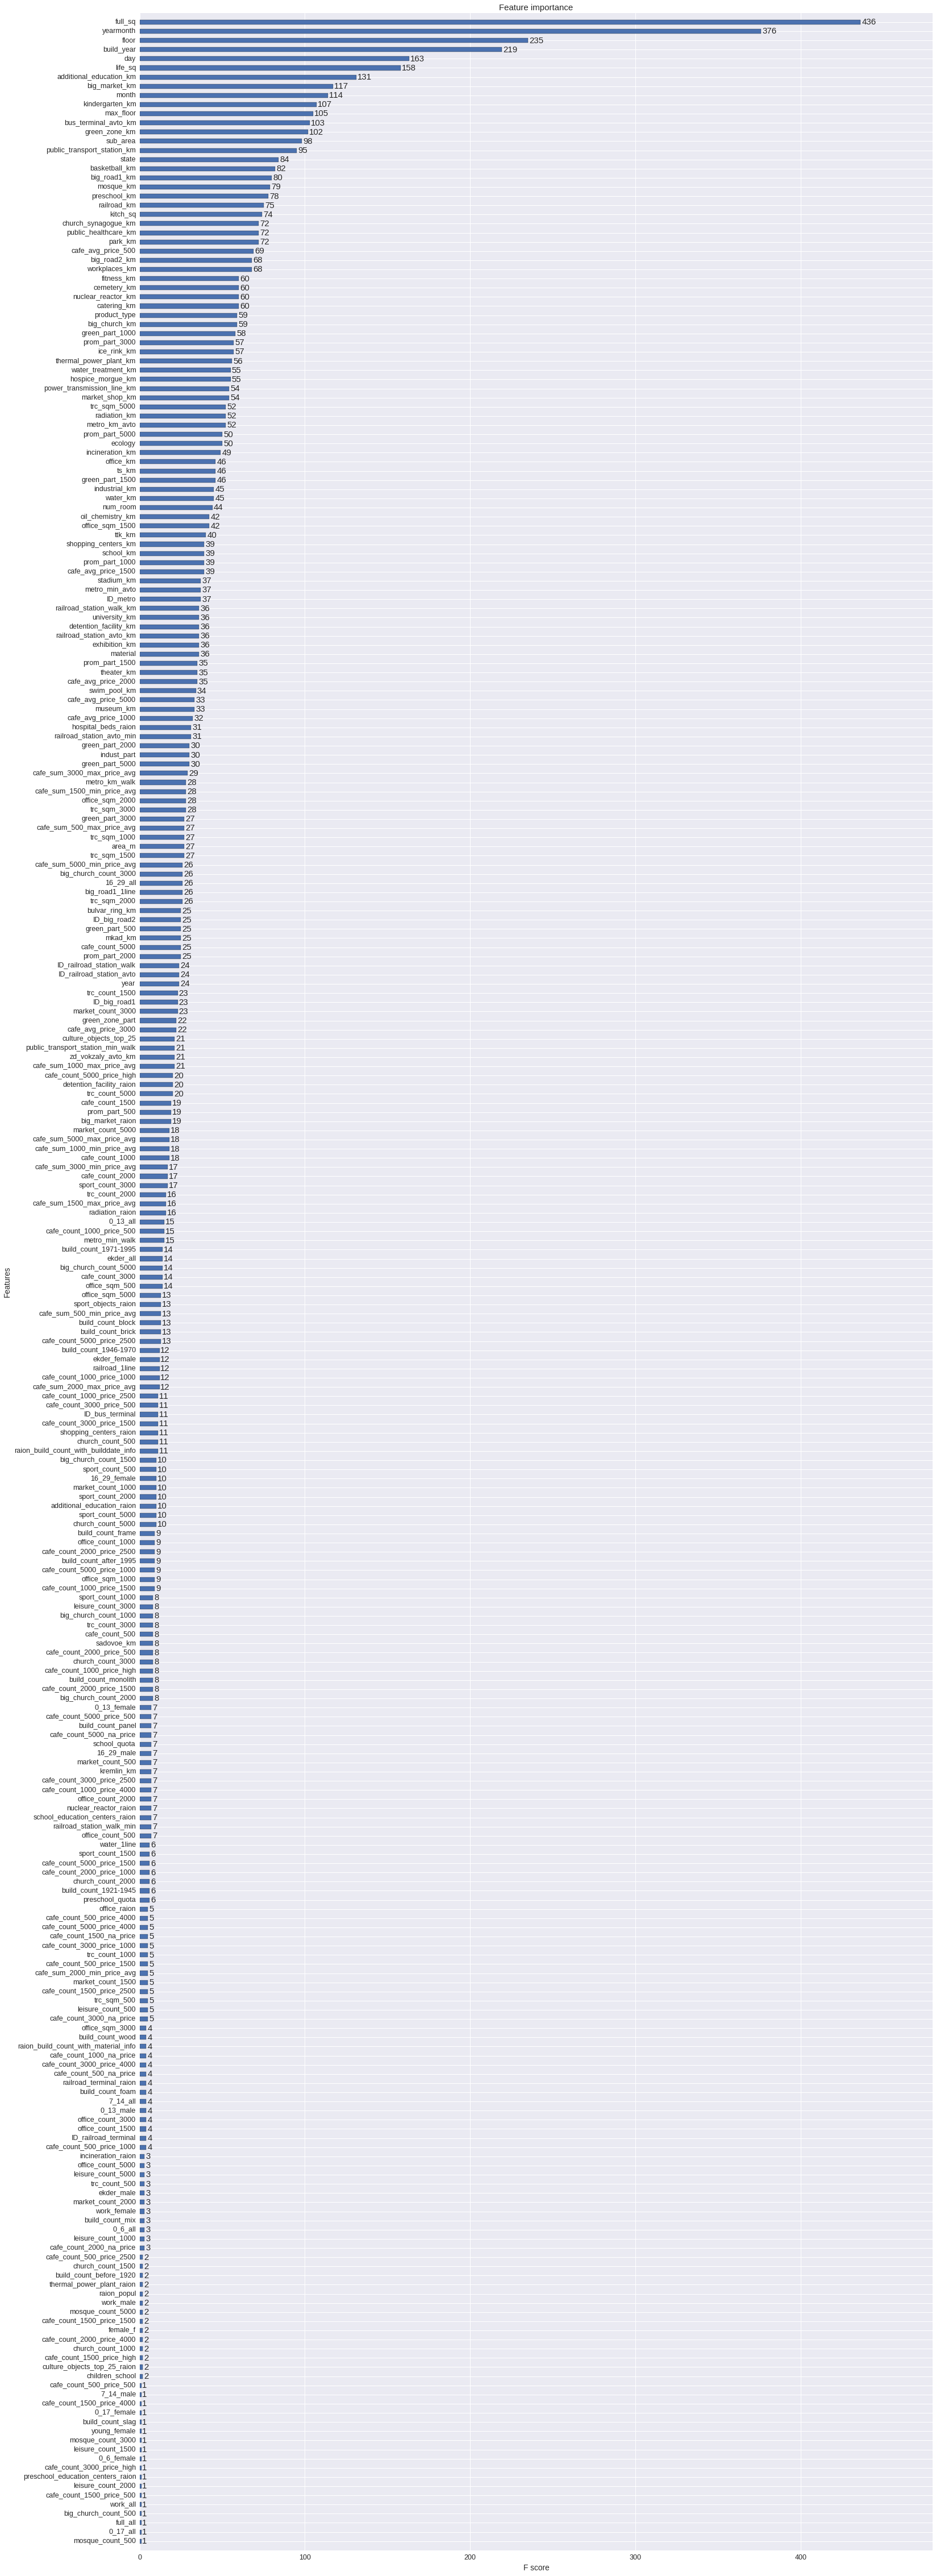

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(25, 80))
xgb.plot_importance(partial_model, height=0.5, ax=ax)

In [106]:
num_boost_round = partial_model.best_iteration

In [108]:
ylog_pred = partial_model.predict(dtest)
y_pred = np.exp(ylog_pred)-1
submission = pd.DataFrame({'id': id_test, 'price_doc': y_pred})

submission.to_csv('submission.csv', index=False)

### This is the initial attempt
### Next steps:
##### Clean the data
##### Perform different feature selection methods and test them
##### Tune on the validation set 
##### Perform Feature engineering

In [120]:
import operator
feat = []
for c in sorted(partial_model.get_fscore().items(), key=operator.itemgetter(1)):
    if c[1] >100:
        feat.append(c[0])

In [131]:
train[feat].shape

(30471, 13)

In [133]:
feat.dims

AttributeError: 'list' object has no attribute 'dims'